In [18]:
import matplotlib.pyplot as plt
import _pickle as cPickle
import pickle
import gzip 
import numpy as np
import sys
import time
from scipy.special import expit


# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f,encoding='latin1')
f.close()

In [21]:
#these are just various mathematical tools needed for the NN

def identity(x):
    return x

def identityPrime(x):
    return np.ones(len(x))

def sigmoidPrime(x):
    return expit(x)*(1-expit(x)) #use expit to prevent overflow with large values

def sigmoid(x):
    return expit(x) #admittedly this is a little unnecessary but I think it makes sense to have 
    #sigmoid and sigmoidPrime instead of expit and sigmoidPrime

def relu(x):
    if x<0:
        return 0
    else:
        return x

def reluPrime(x):
    z = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>0:
            z[i] = 1
    return z

def elementWise(f, x):
    for i in range(len(x)):
        x[i] = f(x[i])
    return x    

def softMax(x):
    z = np.exp(x)
    return z/sum(z)

def softMaxPrime(x):
    z = np.exp(x)
    c = sum(z)
    for i in range(len(z)):
        z[i] = (c-z[i])*z[i]/(c*c)
    return z

def logLoss(x, target):
    loss = 0
    for i in range(len(x)):
        loss += target[i]*np.log(x[i])+(1-target[i])*np.log(1-x[i])
    return (-1.0/len(x))*loss
    
def logLossPrime(x, target):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i]=(-1.0/len(x))*(target[i]/x[i]-(1-target[i])/(1-x[i]))
    return grad

def MSE(x, target):
    a = x-target
    return np.dot(a,a)

def MSEPrime(x, target):
    return 2*(x-target)

def crossEntropy(output, target):
    cost = 0
    for i in range(len(target)):
        cost -= target[i]*np.log(output[i])
    return cost

def crossEntropyPrime(output, target):
    return -target/output

def softMaxCross(x, target):
    return crossEntropy(softMax(x), target)

def softMaxCrossPrime(x, target):
    return softMax(x)-target

def trainingGraph(trainingData):
    costs = trainingData[0]
    accuracies = np.array(trainingData[1])
    plt.plot(costs, 'ro')
    plt.ylabel("total cost")
    plt.xlabel("iteration")
    plt.show()
    plt.plot(100.0*(1.0-accuracies), 'bo')
    plt.ylabel("total error percentage")
    plt.xlabel("iteration")
    plt.show()

class Neural_Network:
    defaultSize = 16 #default number of neurons in hidden layers if no shape list given
    inputChecks = True #this will change whether inputs that match the MNIST format are given
    #can be turned off to allow for debugging on smaller examples
    
    #activation must be an activation function that works for a single scalar 
    #and activation prime is its derivative. costFunction is a cost function for a vector representing an output layer
    #and the target vector. costDeriv is its derivative with respect to the vector of activations.
    #shape is list of integers where shape[i] = the number of neurons in ith layer
    #layers is an integer describing the number of layers, lastAct is an optional change so that on the last layer
    #you can have a different activation function
    #shape and layers are optional. if both are given the shape list will be followed, if neither are given
    #it will use the default value for layers and make all hidden layers have defaultSize many neurons
    #lastAct and lastActPrime are the activation function and its derivative for the last layer. if left blank
    #will default to the given activation and activationPrime
    def __init__(self, activation, activationPrime, costFunction, costDeriv, shape = None, layers = 4, 
                 lastAct = None, lastActPrime = None):
        if layers<2:
            raise NameError("Too few layers. Need an input layer and an output layer.")
        if Neural_Network.inputChecks and (shape[0] != 28**2 or shape[len(shape)-1] != 10):
            raise NameError("Improper input or output layer size. \
                            Must be 28^2 input neurons and 10 output neurons to work with MNIST.")
        if shape==None:
            shape = [28**2] + [defaultSize for i in range(layers-2)] + [10]
        self.activation = activation
        self.activationPrime = activationPrime
        self.shape = shape
        self.costFunction = costFunction
        self.costDeriv = costDeriv
        self.weights = Neural_Network.constructWeights(shape) 
        #weights[i] is the weights going into layer i
        self.bias = Neural_Network.constructBias(shape)
        #bias[i] is the bias on layer i
        if lastAct == None:
            self.lastAct = activation
            self.lastActPrime = activationPrime
        else:
            self.lastAct = lastAct
            self.lastActPrime = lastActPrime
        self.activations = []
        self.zs = []
        
    #returns a list of matrices of weights. weights[i] is the set of weights going into ith layer
    #weights[i][j][k] represents the weight going from the kth neuron in layer i-1 to jth neuron in layer i 
    def constructWeights(shape):
        weights = [None]
        for i in range(len(shape)-1): 
            weights.append(np.random.uniform(-0.1,0.1,shape[i]*shape[i+1]).reshape((shape[i+1],shape[i])))
        return weights
    
    #returns a list of vectors of biases. bias[i] is the set of biases on the ith layer
    #bias[i][j] is the bias in the ith layer on the jth neuron
    def constructBias(shape):
        bias = [None]
        for i in range(1,len(shape)): 
            bias.append(np.random.uniform(-0.1,0.1,shape[i]))
        return bias
    
    #performs forward propagation on the input x with the current weights and biases
    #using activation function from the constructor returns the activations on the last layer 
    #updates the zs and activations attributes
    def forwardProp(self, x):
        if Neural_Network.inputChecks and len(x) != 28**2:
            raise NameError("improper input")
        prevAct = x
        act = []
        self.activations = []
        self.zs = []
        self.activations.append(prevAct)
        for i in range(1,len(self.shape)-1): #each layer except for last
            z = np.dot(self.weights[i], prevAct) + self.bias[i]
            act = elementWise(self.activation, z)
            self.activations.append(act)
            self.zs.append(z)
            prevAct = act
        i = len(self.shape)-1    
        z = np.dot(self.weights[i], prevAct) + self.bias[i]
        act = elementWise(self.lastAct, z)
        self.activations.append(act)
        self.zs.append(z)
        prevAct = act
        return act
    
    #returns the total cost for the neural network on all datapoints in data
    #using cost function costFunc for each point. returns cost as a scalar
    def totalCost(self, data, costFunc):
        images = data[0]
        labels = data[1]
        if Neural_Network.inputChecks and len(images) != len(labels):
            raise NameError("improper input")
        target = np.zeros(10)
        cost = 0 
        for i in range(len(images)):
            target[labels[i]] = 1
            out = self.forwardProp(images[i])
            cost += costFunc(out, target)
            target[labels[i]] = 0
        return cost
        
    #returns the classification as a scalar based on the outputActivations
    #picks the index with highest activation
    def classification(outputActivations):
        maximum = -1
        index = -1
        for i in range(len(outputActivations)):
            if outputActivations[i] >= maximum:
                index = i
                maximum = outputActivations[i]
        return index
     
    #randomly initializes all weights and biases    
    def randomInitialization(self):
        self.weights = Neural_Network.constructWeights(self.shape) 
        self.bias = Neural_Network.constructBias(self.shape)
    
    #using backProp this will perform gradient descent from the current initialization of the weights
    #and biases on the given data. data in form touple of array of images and array of labels
    #will stop after iterations many iterations. returns a touple of the best weights and biases
    #and a list of the costs over time. will update the weights and biases in the neural network
    #suppressPrint will not print anything between steps if set to true
    #costInterval determines how often the cost will be re-computed, saved, printed (if suppressPrint is false)
    #and how often the best weights and biases are saved. when set to 1 it occurs on every step
    def gradientDescent(self, data, iterations, learningRate, suppressPrint = False, costInterval = 1):
        return self.stochasticGradientDescent(data, len(data[0]), iterations, learningRate, suppressPrint, costInterval)
    
    #will apply the gradient with stepSize where the gradient is in form 
    #given by the backProp function
    def applyGradient(self, gradient, stepSize):
        for i in range(1, len(gradient[0])): #for each matrix in the weight update, 
            #first value is None for convenience in indexing
            self.weights[i] -= stepSize * gradient[0][i]
        for i in range(1, len(gradient[1])): #for each vector in the bias update
            self.bias[i] -= stepSize * gradient[1][i]
    
    #computes the correct and incorrect number of classified data points on data
    #prints the number correct, number incorrect, percent correct, and percent incorrect
    #returns a touple of the number correct and total number of data points
    def validation(self, data, suppressPrint = False):
        images = data[0]
        labels = data[1]
        if len(images) != len(labels):
            raise NameError("improper input")
        correct = 0 
        wrong = 0
        for i in range(len(images)):
            if (Neural_Network.classification(self.forwardProp(images[i]))) == labels[i]:
                correct += 1
            else:
                wrong += 1
        if not suppressPrint:
            print("correct: ", correct)
            print("wrong: ", wrong)
            print("accuracy:", 100.0*correct/len(images), "%")
            print("error:", 100.0*wrong/len(images), "%")
        return (correct, len(images))
    
    #chooses a random batch of size batchSize from images and labels
    #note it does not replace when sampling
    def randomBatch(images, labels, batchSize):
        indices = np.random.choice(len(images), batchSize, replace = False)
        #if you set replace to True this will break the gradientDescent function
        imageBatch = []
        labelBatch = []
        for i in range(len(indices)):
            imageBatch.append(images[indices[i]])
            labelBatch.append(labels[indices[i]])
        return (imageBatch, labelBatch)
        
    #using backProp this will perform stoachastic gradient descent from the current initialization of the weights
    #and biases on the given data. will choose batchSize many samples from data 
    #data in form touple of array of images and array of labels
    #will stop after iterations many iterations. returns a touple of the best weights and biases
    #and a list of the costs over time. will update the weights and biases in the neural network
    #suppressPrint will not print anything between steps if set to true
    #costInterval determines how often the cost will be re-computed, saved, printed (if suppressPrint is false)
    #and how often the best weights and biases are saved. when set to 1 it occurs on every step
    def stochasticGradientDescent(self, data, batchSize, iterations, learningRate, suppressPrint = False, costInterval = 5):
        start = time.time()
        bestCost = sys.maxsize
        bestWandB = []
        costs = []
        accuracies = []
        images = data[0]
        labels = data[1]
        for j in range(iterations):
            imageSet, labelSet = Neural_Network.randomBatch(images, labels, batchSize)
            target = np.zeros(10)
            gradients = []
            for i in range(len(imageSet)):
                target[labelSet[i]] = 1
                output = self.forwardProp(imageSet[i])
                gradients.append(self.backProp(target))
                target[labelSet[i]] = 0
            self.applyGradient(self.averageGradient(gradients), learningRate)
            if j % costInterval == 0: #performs this many gradient steps before re-computing the cost for all examples
                #this is somewhat of a hyper-parameter. Higher number = faster runtime but less training data, 
                #less info when it is running about how it is doing, and fewer opportunities to save the best configuration
                cost = self.totalCost(data, self.costFunction)
                costs.append(cost)
                a = self.validation(data, suppressPrint)
                accuracies.append(a[0]/a[1])
                if not suppressPrint:
                    print(cost)
                if cost <= bestCost:#this saves the best configuration so far but only on steps when the cost is computed
                    bestCost = cost
                    bestWandB = (self.weights, self.bias)
        trainingData = (costs, accuracies)
        end = time.time()
        print(iterations, "iterations took", end - start, "seconds.")
        return (bestWandB, trainingData)
    
    #given a list of touples of the gradient in the form given by backProp
    #will return the average gradient
    def averageGradient(self, gradients):
        averageGrad = (Neural_Network.constructWeights(self.shape), Neural_Network.constructBias(self.shape))
        for i in range(len(averageGrad)): #weights then biases
            for j in range(len(gradients)): #grad from each sample
                for k in range(1, len(gradients[j][i])): #grad for each matrix
                    averageGrad[i][k] += gradients[j][i][k]
            for k in range(1,len(averageGrad[i])):#done at end to prevent rounding small numbers to zero
                averageGrad[i][k] /= len(gradients) #if overflow is a problem then divide at each step
        return averageGrad
    
    #this will return the gradient of the cost on the single target
    #the form is a touple with the weights and then the biases
    #in the same format as the weights and biases attributes for the Neural_Network class
    def backProp(self, target):
        if Neural_Network.inputChecks and len(target) != 10:
            raise NameError("improper input")
        biasGrad = [None for _ in range(len(self.shape))]
        weightGrad = [None for _ in range(len(self.shape))]
        delta = self.costDeriv(self.activations[-1], target) * self.lastActPrime(self.zs[-1])
        biasGrad[-1] = delta
        weightGrad[-1] = np.tile(np.array([delta]).transpose(), (1,self.shape[-2]))*np.tile(np.array(self.activations[-2]),(self.shape[-1],1))
        #this line (and the version of it below can be a little confusing, see readme)
        for l in range(2, len(self.shape)):
            z = self.zs[-l]
            actDeriv = self.activationPrime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * actDeriv
            biasGrad[-l] = delta
            weightGrad[-l] = np.tile(np.array([delta]).transpose(), (1,self.shape[-l-1]))*np.tile(np.array(self.activations[-l-1]),(self.shape[-l],1))
        return (weightGrad, biasGrad)
    

The line right before the for loop in ```backProp()``` is a little confusing so I'll explain. $\frac{\partial C}{\partial W^{l}_{j,k}} = a^{l-1}_{k} \Delta^{l}_{j}$ where $C$ is the cost and $W^{l}_{j,k}$ is the weight going from the $k$th neuron in the $l-1$th layer to the $j$th neuron in the $l$th layer, $a^{l-1}_{k}$ is the activation on the $k$th neuron in the $l-1$th layer, and $\Delta^{l}_{j}$ is the derivative of the cost with respect to the $j$th component of $z^{l}$. 

If you've never seen this before, it can be confusing so draw out a simple NN with very few neurons and write out the gradient of the weight matrix. You will notice that if you make a matrix with the same dimensions as $W^{l}$ where the columns are the vector $\Delta^{l}$ and the same dimension matrix where the rows are the row vector $(a^{l-1})^{T}$ and do element-wise multiplication (not matrix multiplication) of these matrices, then the resulting matrix is the gradient of the cost with respect to the weight matrix $W^{l}$.

If you're more comfortable with index notation you can also just see that in the gradient matrix of the cost with respect to the weight $W^{l}$ weights with the same row have the same $\Delta$ value being multiplied. Similarly weights with the same column have the same $a^{l-1}$ value being multiplied.

```np.tile``` allows you to create matrices from repeating column or row vectors. The [NumPy documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.tile.html) explains it much better than I can. Thus in this line I use ```np.tile``` to create a matrix where the columns are the vector $\Delta^{l}$ and a matrix where the rows are $(a^{l-1})^{T}$ and then perform element-wise multiplication. 

correct:  1060
wrong:  8940
accuracy: 10.6 %
error: 89.4 %
500 iterations took 1588.8586869239807 seconds.
correct:  2529
wrong:  7471
accuracy: 25.29 %
error: 74.71 %


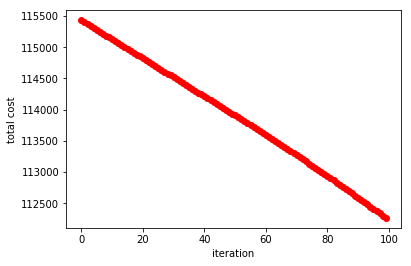

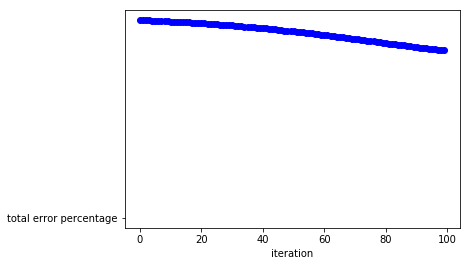

In [45]:
a = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 100, 10])
a.validation(valid_set)
trainingData0 = a.stochasticGradientDescent(train_set, 1000, 500, 0.001, suppressPrint = True)
a.validation(valid_set)
trainingGraph(trainingData0[1])

200 iterations took 597.6910700798035 seconds.
correct:  7310
wrong:  2690
accuracy: 73.1 %
error: 26.9 %


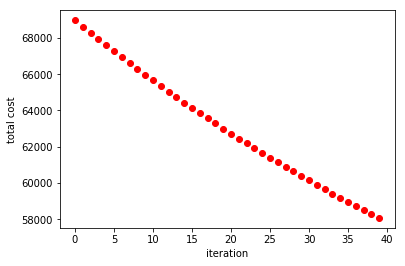

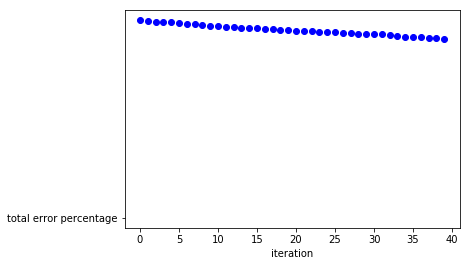

In [47]:
trainingData2 = a.stochasticGradientDescent(train_set, 1000, 200, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingGraph(trainingData2[1])

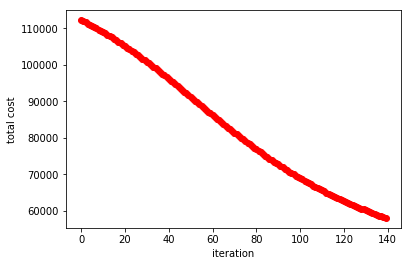

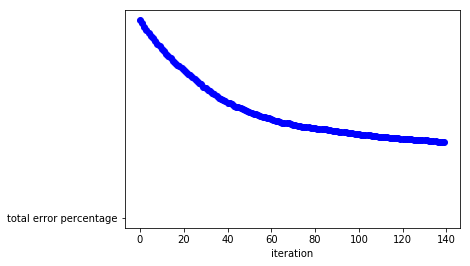

In [49]:
trainingData = [[],[]]
trainingData[0] += trainingData1[1][0] + trainingData2[1][0] 
trainingData[1] += trainingData1[1][1] + trainingData2[1][1]
trainingGraph(trainingData)

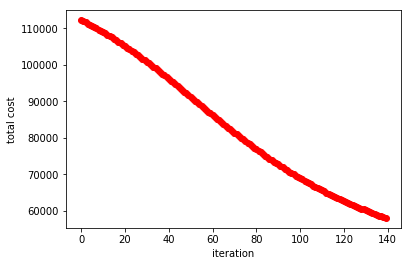

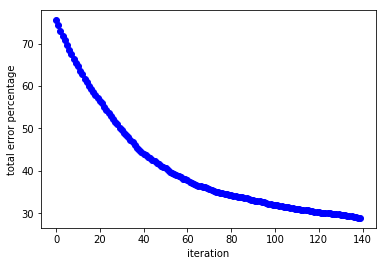

In [50]:
def trainingGraph(trainingData):
    costs = trainingData[0]
    accuracies = np.array(trainingData[1])
    plt.plot(costs, 'ro')
    plt.ylabel("total cost")
    plt.xlabel("iteration")
    plt.show()
    plt.plot(100.0*(1.0-accuracies), 'bo')
    plt.ylabel("total error percentage")
    plt.xlabel("iteration")
    plt.show()
    
trainingGraph(trainingData)

300 iterations took 898.1946411132812 seconds.
correct:  7617
wrong:  2383
accuracy: 76.17 %
error: 23.83 %


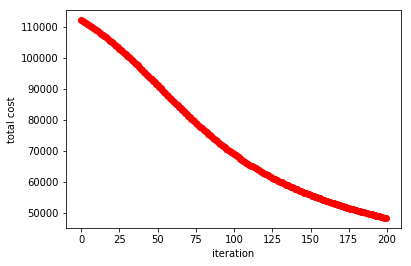

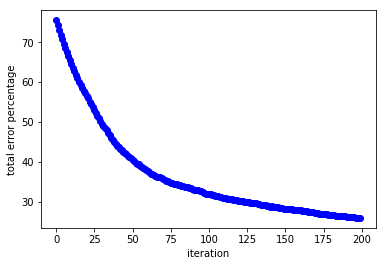

In [51]:
trainingData3 = a.stochasticGradientDescent(train_set, 1000, 300, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData3[1][0] 
trainingData[1] += trainingData3[1][1]
trainingGraph(trainingData)

In [52]:
trainingData4 = a.stochasticGradientDescent(train_set, 1000, 1000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData4[1][0] 
trainingData[1] += trainingData4[1][1]

1000 iterations took 2997.298058986664 seconds.
correct:  8864
wrong:  1136
accuracy: 88.64 %
error: 11.36 %


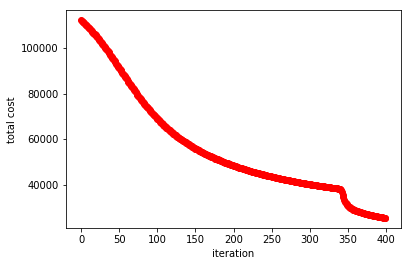

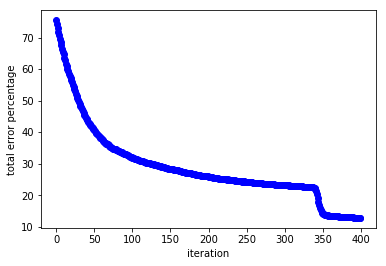

In [53]:
trainingGraph(trainingData)

In [54]:
trainingData5 = a.stochasticGradientDescent(train_set, 1000, 500, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData5[1][0] 
trainingData[1] += trainingData5[1][1]

500 iterations took 1655.6477806568146 seconds.
correct:  8949
wrong:  1051
accuracy: 89.49 %
error: 10.51 %


In [68]:
trainingData6 = a.stochasticGradientDescent(train_set, 1000, 500, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData6[1][0] 
trainingData[1] += trainingData6[1][1]

500 iterations took 1624.1182272434235 seconds.
correct:  9046
wrong:  954
accuracy: 90.46 %
error: 9.54 %


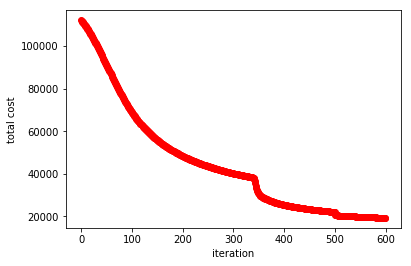

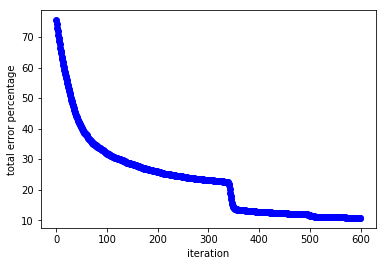

In [69]:
trainingGraph(trainingData)

In [71]:
trainingData7 = a.stochasticGradientDescent(train_set, 1000, 3000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData7[1][0] 
trainingData[1] += trainingData7[1][1]

3000 iterations took 8784.720866203308 seconds.
correct:  9192
wrong:  808
accuracy: 91.92 %
error: 8.08 %


In [78]:
trainingData8 = a.stochasticGradientDescent(train_set, 1000, 3000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData8[1][0] 
trainingData[1] += trainingData8[1][1]

3000 iterations took 8927.946137189865 seconds.
correct:  9284
wrong:  716
accuracy: 92.84 %
error: 7.16 %


In [73]:
b = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 300, 100, 10])
b.validation(valid _set)
bData0 = b.stochasticGradientDescent(train_set, 1000, 5000, 0.008, suppressPrint = True)



correct:  1048
wrong:  8952
accuracy: 10.48 %
error: 89.52 %


KeyboardInterrupt: 

In [83]:
trainingData9 = a.stochasticGradientDescent(train_set, 1000, 3000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData9[1][0] 
trainingData[1] += trainingData9[1][1]

3000 iterations took 8947.409311056137 seconds.
correct:  9343
wrong:  657
accuracy: 93.43 %
error: 6.57 %


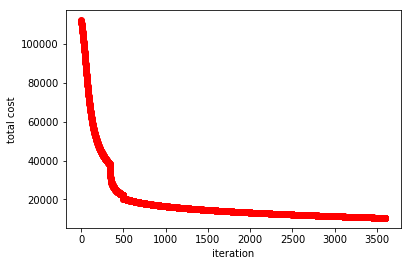

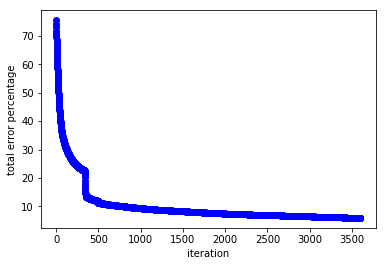

In [99]:
trainingGraph(trainingData)

In [87]:
trainingData10 = a.stochasticGradientDescent(train_set, 1000, 1000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData10[1][0] 
trainingData[1] += trainingData10[1][1]

1000 iterations took 3145.555001974106 seconds.
correct:  9365
wrong:  635
accuracy: 93.65 %
error: 6.35 %


In [90]:
a.validation(train_set)


correct:  46579
wrong:  3421
accuracy: 93.158 %
error: 6.842 %


(46579, 50000)

In [91]:
trainingData11 = a.stochasticGradientDescent(train_set, 1000, 2000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData11[1][0] 
trainingData[1] += trainingData11[1][1]

2000 iterations took 6146.021376132965 seconds.
correct:  9398
wrong:  602
accuracy: 93.98 %
error: 6.02 %


In [96]:
trainingData12 = a.stochasticGradientDescent(train_set, 1000, 3000, 0.008, suppressPrint = True)
a.validation(valid_set)
trainingData[0] += trainingData12[1][0] 
trainingData[1] += trainingData12[1][1]

3000 iterations took 9065.253048181534 seconds.
correct:  9455
wrong:  545
accuracy: 94.55 %
error: 5.45 %


In [100]:
trainingData13 = a.stochasticGradientDescent(train_set, 500, 10000, 0.008, suppressPrint = True, costInterval = 100)
a.validation(valid_set)
trainingData[0] += trainingData13[1][0] 
trainingData[1] += trainingData13[1][1]

10000 iterations took 6055.067192077637 seconds.
correct:  9544
wrong:  456
accuracy: 95.44 %
error: 4.56 %


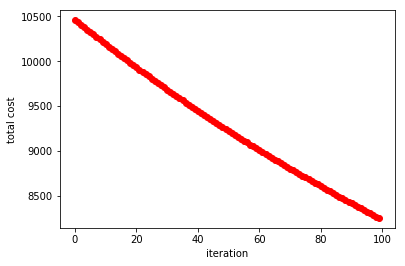

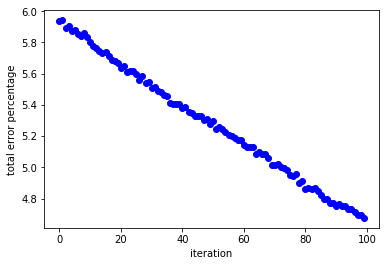

In [110]:
trainingGraph(trainingData13[1])

In [102]:
bData1 = b.stochasticGradientDescent(train_set, 250, 1000, 0.008, suppressPrint = True, costInterval = 20)
bData2 = b.stochasticGradientDescent(train_set, 250, 1000, 0.006, suppressPrint = True, costInterval = 20)

1000 iterations took 2635.764889240265 seconds.
1000 iterations took 2628.222034931183 seconds.


In [109]:
b.validation(train_set)

correct:  45339
wrong:  4661
accuracy: 90.678 %
error: 9.322 %


(45339, 50000)

In [111]:
trainingData13 = a.stochasticGradientDescent(train_set, 500, 10000, 0.008, suppressPrint = True, costInterval = 100)
a.validation(valid_set)
trainingData[0] += trainingData13[1][0] 
trainingData[1] += trainingData13[1][1]

10000 iterations took 6157.3211879730225 seconds.
correct:  9611
wrong:  389
accuracy: 96.11 %
error: 3.89 %


In [112]:
bData3 = b.stochasticGradientDescent(train_set, 250, 2000, 0.006, suppressPrint = True, costInterval = 20)

2000 iterations took 5257.719088792801 seconds.


In [115]:
b.validation(train_set)

correct:  46030
wrong:  3970
accuracy: 92.06 %
error: 7.94 %


(46030, 50000)

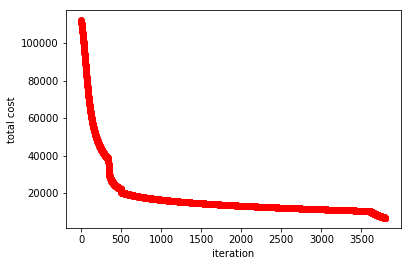

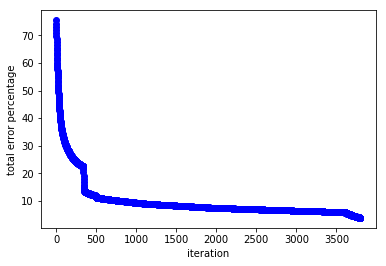

In [116]:
trainingGraph(trainingData)

In [117]:
bData4 = b.stochasticGradientDescent(train_set, 250, 3000, 0.006, suppressPrint = True, costInterval = 20)
b.validation(valid_set)

3000 iterations took 7846.597355127335 seconds.
correct:  9355
wrong:  645
accuracy: 93.55 %
error: 6.45 %


(9355, 10000)

In [118]:
trainingData14 = a.stochasticGradientDescent(train_set, 500, 4000, 0.008, suppressPrint = True, costInterval = 100)
a.validation(valid_set)
trainingData[0] += trainingData14[1][0] 
trainingData[1] += trainingData14[1][1]

4000 iterations took 2665.7319700717926 seconds.
correct:  9621
wrong:  379
accuracy: 96.21 %
error: 3.79 %


In [120]:
a.validation(train_set)

correct:  48250
wrong:  1750
accuracy: 96.5 %
error: 3.5 %


(48250, 50000)

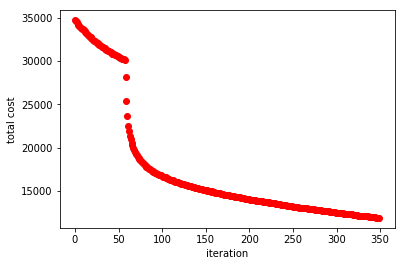

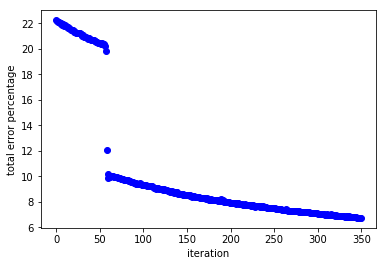

In [122]:
bData = [[],[]] 
bData[0] +=  bData1[1][0] +  bData2[1][0] + bData3[1][0] + bData4[1][0] 
bData[1] +=  bData1[1][1] + bData2[1][1] + bData3[1][1] + bData4[1][1]
trainingGraph(bData)

In [123]:
bData5 = b.stochasticGradientDescent(train_set, 250, 3000, 0.006, suppressPrint = True, costInterval = 20)
bData[0] += bData5[1][0]
bData[1] += bData5[1][1]
b.validation(valid_set)

3000 iterations took 9196.337364912033 seconds.
correct:  9447
wrong:  553
accuracy: 94.47 %
error: 5.53 %


(9447, 10000)

In [125]:
b.validation(train_set)

correct:  47033
wrong:  2967
accuracy: 94.066 %
error: 5.934 %


(47033, 50000)

In [129]:
data={}
data["aData"] = trainingData
data["bData"] = bData
data["a"] = (a.weights, a.bias)
data["b"] = (b.weights, b.bias)
with open('trainingData.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [130]:
with open('trainingData.pickle', 'rb') as handle:
    lastData = pickle.load(handle)
w, b = lastData["a"]

In [131]:
w == a.weights

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [138]:
b = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 300, 100, 10])
b.weights, b.bias = lastData["b"] 

In [140]:
b.validation(valid_set)

correct:  9447
wrong:  553
accuracy: 94.47 %
error: 5.53 %


(9447, 10000)

In [142]:
bData6 = b.stochasticGradientDescent(train_set, 250, 3000, 0.006, suppressPrint = True, costInterval = 20)
bData[0] += bData6[1][0]
bData[1] += bData6[1][1]
b.validation(valid_set)

3000 iterations took 8581.63097500801 seconds.
correct:  9517
wrong:  483
accuracy: 95.17 %
error: 4.83 %


(9517, 10000)

In [143]:
bData7 = b.stochasticGradientDescent(train_set, 250, 7000, 0.006, suppressPrint = True, costInterval = 20)
bData[0] += bData7[1][0]
bData[1] += bData7[1][1]
b.validation(valid_set)

7000 iterations took 18970.66819000244 seconds.
correct:  9606
wrong:  394
accuracy: 96.06 %
error: 3.94 %


(9606, 10000)

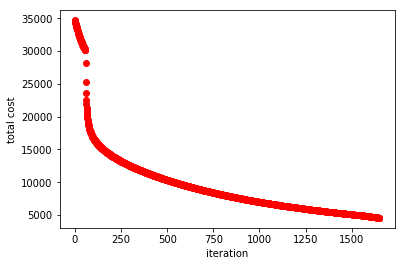

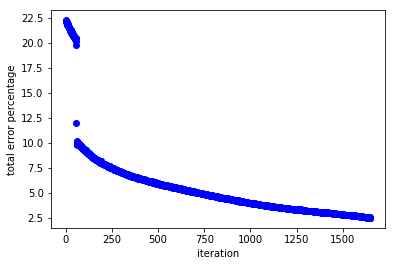

In [171]:
trainingGraph(bData)

In [145]:
bData8 = b.stochasticGradientDescent(train_set, 250, 4000, 0.006, suppressPrint = True, costInterval = 20)
bData[0] += bData8[1][0]
bData[1] += bData8[1][1]
b.validation(valid_set)

4000 iterations took 11594.955529928207 seconds.
correct:  9639
wrong:  361
accuracy: 96.39 %
error: 3.61 %


(9639, 10000)

In [150]:
bData9 = b.stochasticGradientDescent(train_set, 250, 7000, 0.006, suppressPrint = True, costInterval = 20)
bData[0] += bData9[1][0]
bData[1] += bData9[1][1]
b.validation(valid_set)

7000 iterations took 20944.69876599312 seconds.
correct:  9676
wrong:  324
accuracy: 96.76 %
error: 3.24 %


(9676, 10000)

In [151]:
b.validation(test_set)

correct:  9656
wrong:  344
accuracy: 96.56 %
error: 3.44 %


(9656, 10000)

In [153]:
b.validation(train_set)

correct:  48610
wrong:  1390
accuracy: 97.22 %
error: 2.78 %


(48610, 50000)

In [155]:
data={}
data["aData"] = trainingData
data["bData"] = bData
data["a"] = (a.weights, a.bias)
data["b"] = (b.weights, b.bias)
with open('trainingData.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [156]:
bData10 = b.stochasticGradientDescent(train_set, 250, 1000, 0.008, suppressPrint = True, costInterval = 20)
bData[0] += bData10[1][0]
bData[1] += bData10[1][1]
b.validation(valid_set)

1000 iterations took 3000.0413179397583 seconds.
correct:  9675
wrong:  325
accuracy: 96.75 %
error: 3.25 %


(9675, 10000)

In [167]:
b.validation(train_set)

correct:  48663
wrong:  1337
accuracy: 97.326 %
error: 2.674 %


(48663, 50000)

In [168]:
data={}
data["aData"] = trainingData
data["bData"] = bData
data["a"] = (a.weights, a.bias)
data["b"] = (b.weights, b.bias)
with open('trainingData.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [169]:
bData10 = b.stochasticGradientDescent(train_set, 300, 1000, 0.0095, suppressPrint = True, costInterval = 20)
bData[0] += bData10[1][0]
bData[1] += bData10[1][1]
b.validation(valid_set)
b.validation(test_set)

1000 iterations took 3263.502804994583 seconds.
correct:  9678
wrong:  322
accuracy: 96.78 %
error: 3.22 %
correct:  9671
wrong:  329
accuracy: 96.71 %
error: 3.29 %


(9671, 10000)

In [172]:
bData10 = b.stochasticGradientDescent(train_set, 300, 1000, 0.0105, suppressPrint = True, costInterval = 1000)
bData[0] += bData10[1][0]
bData[1] += bData10[1][1]
b.validation(valid_set)
b.validation(test_set)

1000 iterations took 1284.205706834793 seconds.
correct:  9685
wrong:  315
accuracy: 96.85 %
error: 3.15 %
correct:  9672
wrong:  328
accuracy: 96.72 %
error: 3.28 %


(9672, 10000)

In [173]:
b.validation(train_set)

correct:  48786
wrong:  1214
accuracy: 97.572 %
error: 2.428 %


(48786, 50000)

In [174]:
bData11 = b.stochasticGradientDescent(train_set, 300, 2000, 0.0105, suppressPrint = True, costInterval = 1000)
bData[0] += bData11[1][0]
bData[1] += bData11[1][1]
b.validation(valid_set)
b.validation(test_set)

2000 iterations took 2643.803431034088 seconds.
correct:  9693
wrong:  307
accuracy: 96.93 %
error: 3.07 %
correct:  9695
wrong:  305
accuracy: 96.95 %
error: 3.05 %


(9695, 10000)

In [177]:
bData12 = b.stochasticGradientDescent(train_set, 300, 2000, 0.0105, suppressPrint = True, costInterval = 1000)
bData[0] += bData12[1][0]
bData[1] += bData12[1][1]
b.validation(valid_set)
b.validation(test_set)

2000 iterations took 2522.0097200870514 seconds.
correct:  9700
wrong:  300
accuracy: 97.0 %
error: 3.0 %
correct:  9695
wrong:  305
accuracy: 96.95 %
error: 3.05 %


(9695, 10000)

In [178]:
b.validation(train_set)

correct:  49009
wrong:  991
accuracy: 98.018 %
error: 1.982 %


(49009, 50000)

In [179]:
bData13 = b.stochasticGradientDescent(train_set, 300, 200, 0.0105, suppressPrint = True, costInterval = 1000)
bData[0] += bData13[1][0]
bData[1] += bData13[1][1]
b.validation(valid_set)
b.validation(test_set)

200 iterations took 275.1218087673187 seconds.
correct:  9703
wrong:  297
accuracy: 97.03 %
error: 2.97 %
correct:  9694
wrong:  306
accuracy: 96.94 %
error: 3.06 %


(9694, 10000)

In [180]:
training_data={}
training_data["aData"] = trainingData
training_data["bData"] = bData
training_data["a"] = (a.weights, a.bias)
training_data["b"] = (b.weights, b.bias)
with open('training_data.pickle', 'wb') as handle:
    pickle.dump(training_data, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [184]:
c = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 300, 100, 10])
with open('training_data.pickle', 'rb') as handle:
    lastData = pickle.load(handle)
c.weights, c.bias  = lastData["b"]
c.validation(valid_set)


correct:  9703
wrong:  297
accuracy: 97.03 %
error: 2.97 %


(9703, 10000)

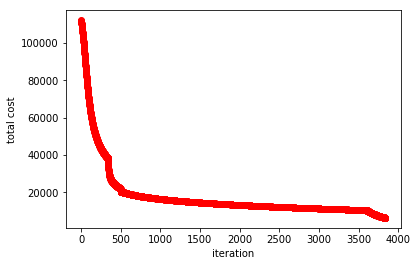

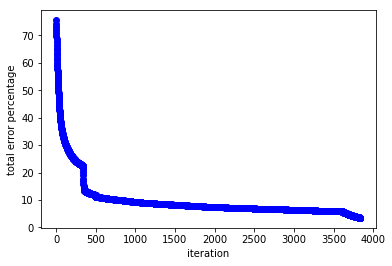

In [185]:
trainingGraph(trainingData)